In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
device

device(type='cpu')

# 1： 建立瑪利歐遊戲環境

In [2]:
import gym
from nes_py.wrappers import JoypadSpace #此wrapper模組透過結合不同動作來縮小動作空間
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT #我們可以匯入的動作空間共有兩種：一種只包含5個動作（simple），另一種則包含12個動作（complex）
import matplotlib.pyplot as plt
import random 

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) #選擇complex的動作空間（有12個離散動作）
episodes = 0

for episode in range(episodes):
    rewards = []
    scores = []
    state = env.reset() #如果遊戲結束，就重置環境
    done = False
    
    while not done:
        #action = env.action_space.sample()
        action = random.choice([3,4,5])
        state, reward, done, info = env.step(action)
        rewards.append(reward)
        scores.append(info['score'])
        
        #plt.imshow(env.render('rgb_array'))
        #plt.pause(0.05)

    #print(info)
    print(max(rewards), min(rewards), len(rewards), info['x_pos'])
    
    plt.figure(figsize = (6,4))
    plt.plot(scores)


# 2： 將狀態資料轉成灰階並進行downsampling

In [3]:
import matplotlib.pyplot as plt
from skimage.transform import resize #該函式庫中內建可調整畫面shape的函式
import numpy as np

def downscale_obs(obs, new_size=(42,42), to_gray=True):   # (240, 256, 3) -> (42, 42)
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2) #為了將圖片轉換成灰階，我們取出obs第二階（顏色通道）中的最大值
    else:
        return resize(obs, new_size, anti_aliasing=True)

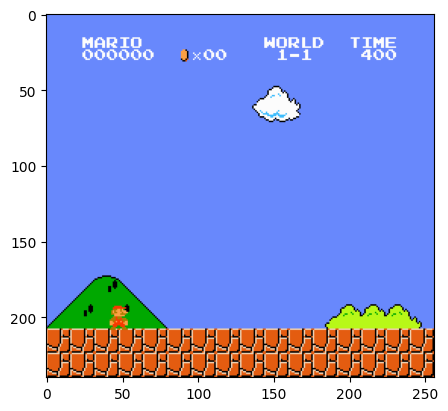

In [4]:
plt.figure(figsize=(5,5))
plt.imshow(env.render("rgb_array")) #呈現原始遊戲畫面

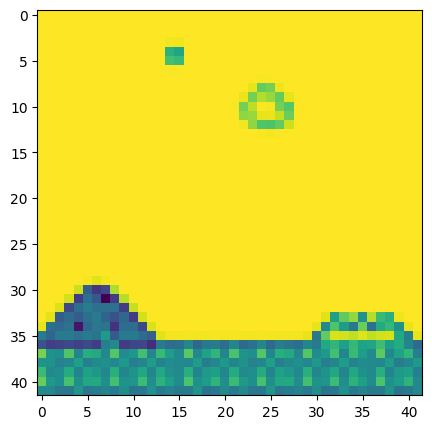

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(downscale_obs(env.render("rgb_array"))) #呈現經過處理的遊戲畫面

# 3： 準備狀態資料

In [6]:
def prepare_state(state):
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def prepare_multi_state(state1, state2): #更新最近的3個遊戲畫面。state1是包含3個遊戲畫面的狀態資料；state2則是最近的遊戲畫面
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float() #調整state2的shape
    state1[0][0] = state1[0][1]  #更新state1的3個遊戲畫面,最舊的畫面被淘汰，加入最新的遊戲畫面
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1

def prepare_initial_state(state,N=3):
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()  # (42,42)
    tmp = state_.repeat((N,1,1)) #將初始遊戲畫面複製三份                     (N=3,42,42)
    return tmp.unsqueeze(dim=0) #在第0階的位置加入批次維度                   (1,N,42,42)

# 4： 策略函數

In [7]:
def policy(qvalues, eps=None): #策略函數接受動作價值向量與ε參數（eps）
    if eps is not None: #若有指定一個eps值，則使用ε—貪婪策略
        if torch.rand(1) < eps:
            return torch.randint(low=0,high=11,size=(1,)) #從12個動作中隨機選取一個來執行
        else:
            return torch.argmax(qvalues)
    else: #若未指定eps值，則使用softmax策略
        return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1) #選擇一個要執行的動作

# 5： 經驗回放

In [8]:
from random import shuffle
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N #N為記憶串列的最大長度
        self.batch_size = batch_size #訓練批次的長度
        self.memory = []
        self.counter = 0

    def add_memory(self, state1, action, reward, state2):
        self.counter +=1
        if self.counter % 500 == 0: #記憶串列每新增500筆資料，便對記憶串列的內容進行洗牌，以更隨機的方式選取訓練批次
            self.shuffle_memory()
        if len(self.memory) < self.N: #若記憶串列未滿，則將資料新增到串列中，否則隨機將串列中的一筆資料替換為新資料
            self.memory.append( (state1, action, reward, state2) )
        else:
            rand_index = np.random.randint(0,self.N-1)#隨機產生串列中要被替換掉的經驗索引
            self.memory[rand_index] = (state1, action, reward, state2)

    def shuffle_memory(self): #使用Python內建的shuffle函式來對記憶串列的內容進行洗牌
        shuffle(self.memory)

    def get_batch(self): #從記憶串列中隨機選取資料出來組成小批次
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        ind = np.random.choice(np.arange(len(self.memory)),batch_size,replace=False) #隨機選出要組成訓練批次的經驗索引
        batch = [self.memory[i] for i in ind]
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch],dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch],dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

# 6： 建構ICM中的各模型

In [9]:
class Phi(nn.Module): #Phi代表編碼器網路
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) #輸出的大小為 [1,32,3,3]
        y = y.flatten(start_dim=1) #shape扁平化成N,288
        return y

class Gnet(nn.Module): #Gnet代表反向模型
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576,256)
        self.linear2 = nn.Linear(256,12)

    def forward(self, state1,state2):
        x = torch.cat( (state1, state2) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y,dim=1)
        return y

class Fnet(nn.Module): #Fnet代表正向模型
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300,256)
        self.linear2 = nn.Linear(256,288)

    def forward(self,state,action):
        action_ = torch.zeros(action.shape[0],12) #將執行的動作批次編碼成one-hot向量
        indices = torch.stack( (torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat( (state,action_) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

# 7： 定義DQN模型

In [10]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.linear1 = nn.Linear(288,100)
        self.linear2 = nn.Linear(100,12)

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y)
        return y

# 8： 超參數與模型實例

In [11]:
params = {
    'batch_size':150,
    'beta':0.2,
    'lambda':0.1,
    'eta': 1.0 ,
    'gamma':0.2,
    'max_episode_len':100,
    'min_progress':15,
    'action_repeats':6,
    'frames_per_state':3
}

replay = ExperienceReplay(N=1000, batch_size=params['batch_size'])

Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()

forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()

all_model_params = list(Qmodel.parameters()) + list(encoder.parameters()) #我們將不同模型的參數加到同一串列中，再將該串列傳給單一優化器
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

# 9： 損失函數與重置環境函式

In [12]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params['beta']) * inverse_loss
    loss_ += params['beta'] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params['lambda'] * q_loss
    
    return loss

def reset_env():
    env.reset()
    state1 = prepare_initial_state(env.render('rgb_array'))
    return state1

# 10： 計算ICM的預測誤差

In [13]:
def ICM(state1, action, state2, forward_scale=1., inverse_scale=1e4):
    
    #使用編碼器將狀態1和2（兩個連續狀態）編碼
    state1_hat = encoder(state1) 
    state2_hat = encoder(state2)
    
    #利用正向模型預測新的狀態
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach()) 
    forward_pred_err = forward_scale * forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
    
    #反向模型傳回各動作的機率分佈
    pred_action = inverse_model(state1_hat, state2_hat) 
    inverse_pred_err = inverse_scale * inverse_loss(pred_action, action.detach().flatten()).unsqueeze(dim=1)
    
    return forward_pred_err, inverse_pred_err

# 11： 使用經驗回放進行小批次訓練

In [14]:
def minibatch_train(use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()

    action_batch = action_batch.view(action_batch.shape[0], 1) #在此張量中增加一個維度，以符合模型的需求
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)
    
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch) #運行ICM
    
    i_reward = (1. / params['eta']) * forward_pred_err #使用eta參數來調整預測誤差的權重
    reward = i_reward.detach() #把i_reward張量從運算圖中分離，並開始計算總回饋值
    
    if use_extrinsic: #決定演算法是否要使用外在回饋值
        reward += reward_batch
        
    qvals = Qmodel(state2_batch) #計算新狀態的動作價值
    
    reward += params['gamma'] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    
    #action_batch是由整數組成的張量，且每個整數代表一個動作的索引值，這裡將它們轉換成由多個one-hot編碼向量組成的張量。
    indices = torch.stack((torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0) 
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    
    return forward_pred_err, inverse_pred_err, q_loss

# 12： 主要訓練迴圈

In [15]:
from IPython.display import clear_output

epochs = 7500
env.reset()
state1 = prepare_initial_state(env.render('rgb_array'))
eps = 0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params['frames_per_state'])
e_reward = 0.
ep_lengths = []

last_x_pos = 40 #用來追踪馬利歐是否有在前進，若很久沒前進則重置遊戲

use_extrinsic = False #使用外在回饋值

for i in range(epochs):
    print("Epochs:",i,"Game progress:",last_x_pos)
    clear_output(wait=True)
    opt.zero_grad()
    episode_length += 1
    
    #運行DQN並預測一個動作價值向量
    q_val_pred = Qmodel(state1) 
    
    #在1,000次訓練過後，換成 ε—貪婪策略
    if i > switch_to_eps_greedy: 
        action = int(policy(q_val_pred, eps))
    else:
        action = int(policy(q_val_pred))
    
    #為加速學習，將選擇的動作重複6次    
    for j in range(params['action_repeats']): 
        state2, e_reward_, done, info = env.step(action)
        last_x_pos = info['x_pos']
        if done:
            if info["flag_get"]:
                e_reward_ += 50
            else:
                e_reward_ -= 50
            
            state1 = reset_env()
            break
        e_reward += e_reward_
        
        state_deque.append(prepare_state(state2))
        
    state2 = torch.stack(list(state_deque), dim=1) #將state_deque串列轉換成張量
    replay.add_memory(state1, action, e_reward, state2) #將單一經驗資料存入經驗池
    e_reward = 0
    
    #若瑪利歐未在遊戲中前進足夠距離，則將遊戲重啟，再試一次
    if episode_length > params['max_episode_len']: 
        if (info['x_pos'] - last_x_pos) < params['min_progress']:
            done = True
        else:
            last_x_pos = info['x_pos']
            
    if done:
        ep_lengths.append(info['x_pos'])
        state1 = reset_env()
        last_x_pos = 40
        episode_length = 0
    else:
        state1 = state2
        
    if len(replay.memory) < params['batch_size']:
        continue
    
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_extrinsic=use_extrinsic) #根據從經驗池選出的一小批次資料，計算各模型的誤差
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err) #計算整體損失
    loss_list = (q_loss.mean(), forward_pred_err.flatten().mean(), inverse_pred_err.flatten().mean())
    losses.append(loss_list)
    
    loss.backward()
    opt.step()

Epochs: 7499 Game progress: 434


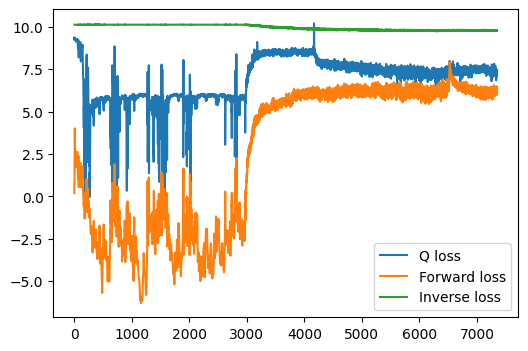

In [16]:
losses_ = []
for l in losses:
    o = []
    for i in range(len(l)):
        o.append(l[i].item())
    losses_.append(o)

losses_ = np.array(losses_)
plt.figure(figsize = (6,4))
plt.plot(np.log(losses_[:,0]),label='Q loss')
plt.plot(np.log(losses_[:,1]),label='Forward loss')
plt.plot(np.log(losses_[:,2]),label='Inverse loss')
plt.legend()
plt.show()

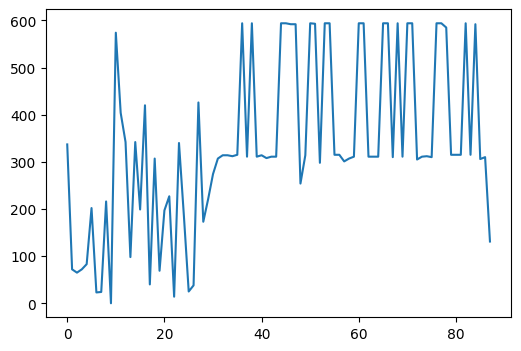

In [17]:
plt.figure(figsize = (6,4))
plt.plot(np.array(ep_lengths), label='Episode length')

In [18]:
eps=0.1
done = True
state_deque = deque(maxlen=params['frames_per_state'])

# Test

In [22]:
import time

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT) #選擇complex的動作空間（有12個離散動作）
episode = 3

for episode in range(1, episode+1):
    states = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render()
        q_val_pred = Qmodel(state1)
        action = int(policy(q_val_pred, eps))
        state2, reward, done, info = env.step(action)
        state2 = prepare_multi_state(state1,state2)
        score += reward
        state1 = state2
        #time.sleep(0.000000001)
    print('Episode:{}, Total rewards:{}, last_position:{}, Score:{}'.format(episode, score, info['x_pos'], info['score']))
env.close()

Episode:1 Total rewards:510.0 last_position:594 Score100
Episode:2 Total rewards:737.0 last_position:313 Score0
Episode:3 Total rewards:514.0 last_position:594 Score100
